In [176]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import math
from xlrd import open_workbook
import xlsxwriter
import pickle
import time

#### UTILITY FUNCTIONS

In [14]:
def load_mat_from_excel(location):
    
    matrix = None
    
    workbook = open_workbook(location)
    worksheet = workbook.sheets()[0]
    
    n_rows = worksheet.nrows
    n_cols = worksheet.ncols
    
    mat = []
    
    for i in range(n_rows):
        row = []
        for j in range(n_cols):
            value = float(worksheet.cell(i,j).value)
            row.append(value)
        mat.append(np.array(row))
        
    mat = np.array(mat)
    
    print("\t\tLOADED MATRIX FROM: " + location)
            
    return mat

In [15]:
def print_matrix(matrix, filename):
        
    workbook = xlsxwriter.Workbook(filename + '.xlsx')
    worksheet = workbook.add_worksheet()
        
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            worksheet.write(i, j , matrix[i][j])
            
    print("\t\tSAVED MATRIX TO: " + filename + '.xlsx')
    
    workbook.close()
            
    return None

#### EVALUATOR INPUT DATA

In [150]:
# 1. LOAD RAW SCORE MATRIX

score_matrix = load_mat_from_excel('Values/score_matrix.xlsx')

# 2. LOAD CLASSES (TRAINING SET LABELS)

file = open('/Users/abhijeetjagdev/facenet/classifiers/CASIA-20_classifier.pkl', 'rb')
_, classes = pickle.load(file, encoding = 'latin1')
labels_train = np.array(classes, dtype = float)

# 3. LOAD TEST SET LABELS

labels_test = load_mat_from_excel('/Users/abhijeetjagdev/facenet/src/values/paths.xlsx')
labels_test = labels.reshape(len(labels),)

		LOADED MATRIX FROM: /Users/abhijeetjagdev/facenet/src/values/score_matrix.xlsx
		LOADED MATRIX FROM: /Users/abhijeetjagdev/facenet/src/values/paths.xlsx


In [139]:
 """
        INPUTS: 
        
                 score_matrix: np.array(n_images_test, classes)
            decision_matrix_T: np.array(n_images_test, classes) (computed using provided T value)
                            T: Float [0.0, 1.0]
                      classes: List(n_classes)
                  labels_test: np.array(n_images_test,)
                            K: int (number of threshold values to use when plotting DET graph)
                   model_name: String
                 dataset_name: String
                
        OUTPUTS: None
        
"""

#score_matrix = load_mat_from_excel('/Users/abhijeetjagdev/facenet/src/values/score_matrix.xlsx')
#decision_matrix_T = load_mat_from_excel('Values/decision_matrix.xlsx')
T = 0.90
#file = open('/Users/abhijeetjagdev/facenet/classifiers/CASIA-20_classifier.pkl', 'rb')
#_, classes = pickle.load(file, encoding = 'latin1')
#labels_test = load_mat_from_excel('Values/labels_test.xlsx')
K = 1000
model_name = 'Inception_v3'
dataset_name = 'CASIA'

#### EVALUATE FACE RECOGNITION PERFORMANCE

In [165]:
# 4.6

def generate_report(GT_matrix, best_match_matrix, decision_matrix, T, fnmr_T, fmr_T, state_vector, probs, CNN_name, dataset_name):
    
    """
        INPUTS:
        
                  GT_matrix: np.array(n_images_test, classes)
          best_match_matrix: np.array(n_images_test, 2)
            decision_matrix: np.array(n_images_test, classes)
                          T: Float [0.0, 1.0]
                     fnmr_T: Float
                      fmr_T: Float
               state_vector: List(n_images_test)
                      probs: np.array(3, 2)
                   CNN_name: String
               dataset_name: String
             
        OUTPUTS: None
        
    """
    print("\t4.7: GENERATING EVALUATION REPORT")
    
    file_name = CNN_name + '_' + dataset_name + '_.xlsx'
    file_location = '/Users/abhijeetjagdev/face-recognition-evaluation-framework/Reports/' + file_name
    workbook = xlsxwriter.Workbook(file_location)
    
    worksheet1 = workbook.add_worksheet()            # 4. EVALUATION METRICS: By Test Sample
    worksheet2 = workbook.add_worksheet()            # 4. EVALUATION METRICS: By Sample State
    worksheet3 = workbook.add_worksheet()            # 4. EVALUATION METRICS: By Set
    worksheet4 = workbook.add_worksheet()            # 1. DATASET SUMMARY

    # SQUISH GT, BEST MATCH, & DECISION MATRICES
    
    GT_vector = np.sum(GT_matrix, axis = 1)
    BM_vector = best_match_matrix[:,0]
    D_vector = np.sum(decision_matrix, axis = 1)
    
    # WORKSHEET 1
    
    headings1 = ['TEST SAMPLE', 'GT VALUE', 'SCORE', 'DECISION @ T = ' + str(T), 'STATE']
    
    for i in range(len(headings1)):
        worksheet1.write(0, i , headings1[i])
        
    for i in range(len(GT_vector)):
        worksheet1.write(i + 1, 0, i + 1)
        worksheet1.write(i + 1, 1, GT_vector[i])
        worksheet1.write(i + 1, 2, BM_vector[i])
        worksheet1.write(i + 1, 3, D_vector[i])
        worksheet1.write(i + 1, 4, state_vector[i])
        
    # WORKSHEET 2
    
    headings2 = ['CASE', 'AVG. PROBABILITY ABOVE', 'AVG. PROBABILITY BELOW']
    states = ['MA', 'DNMA', 'NK']
    
    for i in range(len(headings2)):
        worksheet2.write(0, i, headings2[i])
    
    for i in range(len(states)):
        worksheet2.write(i + 1, 0, states[i])
    
    for i in range(len(probs)):
        for j in range(len(probs[i])):
            worksheet2.write(i + 1, j + 1, probs[i][j])
        
    # WORKSHEET 3
    
    headings3 = ['FMR @ T = ' + str(T), 'FNMR @ T = ' + str(T)]
    
    for i in range(len(headings3)):
        worksheet3.write(0, i, headings3[i])
    
    worksheet3.write(1, 0, fmr_T)
    worksheet3.write(1, 1, fnmr_T)
    
    # WORKSHEET 4
    
    headings4 = ['TRAIN SET', 'TEST SET']
    subheadings4 = ['SIZE', 'SUBJECT COUNT', 'MIN. IMAGE COUNT', 'MAX. IMAGE COUNT']
    
    for i in range(len(headings4)):
        worksheet4.write(0, i + 1, headings4[i])
        
    for i in range(len(subheadings4)):
        worksheet4.write(i + 1, 0, subheadings4[i])
    
    workbook.close()
        
    return None

In [181]:
 # 4.5

def create_DET(model_names, fmr_vals_arr, fnmr_vals_arr, FMR_L, FMR_U):
    
    """
        INPUTS: 
        
              model_names: List(n_models)
            fnmr_vals_arr: np.array(n_models,K)
             fmr_vals_arr: np.array(n_models,K)
                    FMR_L: float
                    FMR_U: float
                
        OUTPUTS: None
        
    """
    
    print("\t4.5: CREATING DET GRAPH")
    plt.title('Detection Error Tradeoff (DET) Graph')
    
    for i in range(len(fmr_vals_arr)):
            plt.step(fmr_vals_arr[i], fnmr_vals_arr[i], label = model_names[i])

    plt.legend()
    plt.ylim(FMR_L, FMR_U)
    plt.ylabel('FNMR')
    plt.xlabel('FMR')
    plt.xscale('log')
    plt.yscale('log')
    plt.savefig('Graphs/' + str(time.ctime(int(time.time()))) + '.png')
    
    return None

In [142]:
# 4.4

def generate_evaluation_metrics(T_vals, genuine_scores, imposter_scores, t):
    
    """
        INPUTS: 
        
                     T_vals: np.array(K,)
             genuine_scores: np.array(n_genuine,)
            imposter_scores: np.array(n_imposter,)
                          T: Float[0.0, 1.0]
                
        OUTPUTS:
        
             fmr_vals: np.array(K,)
            fnmr_vals: np.array(K,)
               fnmr_T: Float
                fmr_T: Float
        
    """
    
    print("\t4.4: COMPUTING FNMR & FMR PAIRS FOR COMPUTED T VALUES")
    
    fmr_vals, fnmr_vals = [], []
    
    for T in T_vals:
        fnmr = 1 - (sum(i > T for i in genuine_scores) / float(len(genuine_scores)))
        fnmr_vals.append(fnmr)
        fmr = sum(i > T for i in imposter_scores) / float(len(imposter_scores))
        fmr_vals.append(fmr)
        
    fnmr_T = 1 - (sum(i > t for i in genuine_scores) / float(len(genuine_scores)))
    fmr_T = sum(i > t for i in imposter_scores) / float(len(imposter_scores))
    
    print("\t4.4: FNMR @ T = " + str(t) + " = " + str(fnmr_T))
    print("\t4.4: FMR @ T = " + str(t) + " = " + str(fmr_T))
        
    return np.array(fmr_vals), np.array(fnmr_vals), fnmr_T, fmr_T

In [143]:
# 4.3
# TODO: add quantile function (LOW PRIORITY)

def create_threshold_vector(FMR_L, FMR_U, K):
    
    """
        INPUTS: 
        
            FMR_L: float(n_images_test, 1)
            FMR_U: float(# of training set classes)
                K: int (number of threshold values to use when plotting DET graph)
                
        OUTPUTS:
        
           T_vals: np.array(K,)
        
    """
        
    print("\t4.3: COMPUTING THRESHOLD VALUE VECTOR (SIZE = " + str(K) + ") FOR PLOTTING DETECTION ERROR TRADEOFF (DET) GRAPH")
    
    FMR_K, T_vals = [], np.array([])
    
    for k in range(0, K):
        FMR_K.append(pow(10, math.log10(FMR_L) + (k / float(K)) * (math.log10(FMR_U) - math.log10(FMR_L))))
        T_vals = 1 - np.array(FMR_K)
        # T_vals = quantile_fn(1 - np.array(FMR_K))
        
    print
        
    return T_vals

In [157]:
def probability_around_T(array, T):
    
    prob_above, prob_below = 0, 0
    n_above, n_below = 0, 0
    above, below = 0, 0
    
    for el in array:
        if el >= T:
            prob_above = prob_above + el
            n_above = n_above + 1
        elif el < T:
            prob_below = prob_below + el
            n_below = n_below + 1
            
    if (n_above == 0):
        above = -1
    else:
        above = float(prob_above)/n_above
        
    if (n_below == 0):
        below = -1
    else:
        below = float(prob_below)/n_below
            
    return above, below

In [155]:
# 4.2

def compute_attempts(score_matrix, GT_matrix, T):
    
    """
        INPUTS: 
        
            score_matrix: np.array(n_images_test, classes)
               GT_matrix: np.array(n_images_test, classes)
                       T: Float [0.0, 1.0]
                
        OUTPUTS:
            
               genuine_scores: np.array(n_genuine_attempts,)
              imposter_scores: np.array(n_imposter_attempts,)
            best_match_matrix: np.array(n_images_test, 2)
                 state_vector: List(n_images_test)
                        probs: List(6)
        
    """
        
    print("\t4.2: COMPUTING GENUINE AND IMPOSTER ATTEMPT SCORE VECTORS")
    
    genuine_scores, imposter_scores, state_vector, states = [], [], [], ['MA', 'DNMA', 'NK']
    imposter_scores1, imposter_scores2 = [], []
    avg_prob_aT_1, avg_prob_bT_1 = 0, 0
    avg_prob_aT_2, avg_prob_bT_2 = 0, 0
    avg_prob_aT_3, avg_prob_bT_3 = 0, 0
             
    print("\t4.2: CREATING BEST MATCH MATRIX")
    
    best_scores_value = np.amax(score_matrix, axis = 1).reshape((len(score_matrix),1))
    best_scores_index = np.argmax(score_matrix, axis = 1).reshape((len(score_matrix),1))
    best_match_matrix = np.concatenate((best_scores_value, best_scores_index), axis = 1)
    
    for i in range(len(best_match_matrix)):
        
        # COUNT GENUINE ATTEMPTS: test subject is known and best matched to correct identity
        
        if (GT_matrix[i][int(best_match_matrix[i][1])] == 1.):
            genuine_scores.append(best_match_matrix[i][0])
            print("\t\tCALCULATING PROBABILITIES AROUND T FOR GENUINE ATTEMPTS")
            avg_prob_aT_1, avg_prob_bT_1 = probability_around_T(genuine_scores, T)
            state_vector.append(states[0])
        
        # COUNT IMPOSTER ATTEMPTS    
    
        else:
            imposter_scores.append(best_match_matrix[i][0])
            
            ### CASE 1: EXPLICIT IMPOSTER ATTEMPT: test subject is not known
            if (np.sum(GT_matrix[i]) == 0.0):
                imposter_scores1.append(best_match_matrix[i][0])
                print("\t\tCALCULATING PROBABILITIES AROUND T FOR EXPLICITY IMPOSTER ATTEMPTS")
                avg_prob_aT_2, avg_prob_bT_2 = probability_around_T(imposter_scores1, T)
                state_vector.append(states[2])
            
            ### CASE 2: IMPLICIT IMPOSTER ATTEMPT: test subject is known but best matched with other a different known subject
            else:
                imposter_scores2.append(best_match_matrix[i][0])
                print("\t\tCALCULATING PROBABILITIES AROUND T FOR IMPLICIT IMPOSTER ATTEMPTS")
                avg_prob_aT_3, avg_prob_bT_3 = probability_around_T(imposter_scores2, T)
                state_vector.append(states[1])
    
    probs = [avg_prob_aT_1, avg_prob_bT_1, avg_prob_aT_2, avg_prob_bT_2, avg_prob_aT_3, avg_prob_bT_3]
    probs = np.array(probs).reshape(3,2)
    
    return np.array(genuine_scores), np.array(imposter_scores), best_match_matrix, state_vector, probs

In [154]:
# 4.1

def create_GT_matrix(labels_test, labels_train):
    
    """
        INPUTS: 
        
              labels_test: np.array(n_images_test,)
             labels_train: np.array(n_images_train,)
                
        OUTPUTS:
        
                GT_matrix: np.array(n_images_test, classes)
        
    """
    
    print("\t4.1: COMPUTING GROUND TRUTH MATRIX FOR EVALUATION")
    
    le = preprocessing.LabelEncoder().fit(labels_train.tolist())
    classes = le.classes_
    n_classes = len(classes)
    GT_matrix = np.zeros((len(labels_test), n_classes))
    
    for i in range(len(labels_test)):
        if labels_test[i] in classes.tolist():
            GT_matrix[i][classes.tolist().index(labels_test[i])] = 1
            
    return GT_matrix

In [146]:
# 3.3

def create_decision_matrix(score_matrix, T):
    
    """
        INPUTS: 
        
            score_matrix: np.array(n_images, embedding_size)
                       T: float (in range [0.0, 1.0])
                
        OUTPUT:
        
            predictions: array(n_images, n_classes)
            
    """
    
    print("\t3.3: COMPUTING DECISION MATRIX @ T = " + str(T))
    
    decision_matrix = np.zeros(score_matrix.shape)
    max_index = score_matrix.argmax(axis = 1)
    
    for i in range(len(max_index)):
        decision_matrix[i][max_index[i]] = score_matrix[i][max_index[i]]
    
    decision_matrix[decision_matrix > T] = 1
    decision_matrix[decision_matrix < T] = 0
    
    return decision_matrix

In [179]:
# 4.0

def evaluate_predictions(score_matrix, T, labels_train, labels_test, K, model_name, dataset_name):
    
    """
        INPUTS: 
        
                 score_matrix: np.array(n_images_test, classes)
                            T: Float [0.0, 1.0]
                 labels_train: np.array(n_images_train,)
                  labels_test: np.array(n_images_test,)
                            K: int (number of threshold values to use when plotting DET graph)
                   model_name: String
                 dataset_name: String
                
        OUTPUTS: None
        
    """
    
    print("\n##################################### EVALUATOR ####################################")
    print("\n4.0: EVALUATING FACE RECOGNITION METRICS\n")
    
    models, fmr_vals_arr, fnmr_vals_arr = [], [], []

    GT_matrix = create_GT_matrix(labels_test, labels_train)
    decision_matrix_T = create_decision_matrix(score_matrix, T)
    genuine_scores, imposter_scores, best_match_matrix, state_vector, probs = compute_attempts(score_matrix, GT_matrix, T)
    FMR_L, FMR_U = 3.0 / float(imposter_scores.shape[0]), 1.0
    T_vals = create_threshold_vector(FMR_L, FMR_U, K)
    fmr_vals, fnmr_vals, fnmr_T, fmr_T = generate_evaluation_metrics(T_vals, genuine_scores, imposter_scores, T)
    
    generate_report(GT_matrix, best_match_matrix, decision_matrix_T, T, fnmr_T, fmr_T, state_vector, probs, model_name, dataset_name)
    
    
    models.append(model_name)
    fmr_vals_arr.append(fmr_vals)
    fnmr_vals_arr.append(fnmr_vals)
    
    create_DET(models, np.array(fmr_vals_arr), np.array(fnmr_vals_arr), FMR_L, FMR_U)
    
    print()
    print_matrix(GT_matrix, 'Values/GT_matrix_' + model_name + '_' + dataset_name)
    print_matrix(genuine_scores.reshape(len(genuine_scores), 1), 'Values/genuine_scores_' + model_name + '_' + dataset_name)
    print_matrix(imposter_scores.reshape(len(imposter_scores), 1), 'Values/imposter_scores_' + model_name + '_' + dataset_name)
    print_matrix(best_match_matrix, 'Values/best_match_matrix_'+ model_name + '_' + dataset_name)
    print_matrix(state_vector, 'Values/state_vector_'+ model_name + '_' + dataset_name)
    print_matrix(T_vals.reshape(len(T_vals), 1), 'Values/T_vals_'+ model_name + '_' + dataset_name)
    print_matrix(fmr_vals.reshape(len(fmr_vals), 1), 'Values/fmr_vals_' + model_name + '_' + dataset_name)
    print_matrix(fnmr_vals.reshape(len(fnmr_vals), 1), 'Values/fnmr_vals_'+ model_name + '_' + dataset_name)
        
    return None


##################################### EVALUATOR ####################################

4.0: EVALUATING FACE RECOGNITION METRICS

	4.1: COMPUTING GROUND TRUTH MATRIX FOR EVALUATION
	3.3: COMPUTING DECISION MATRIX @ T = 0.9
	4.2: COMPUTING GENUINE AND IMPOSTER ATTEMPT SCORE VECTORS
	4.2: CREATING BEST MATCH MATRIX
	4.3: COMPUTING THRESHOLD VALUE VECTOR (SIZE = 1000) FOR PLOTTING DETECTION ERROR TRADEOFF (DET) GRAPH
	4.4: COMPUTING FNMR & FMR PAIRS FOR COMPUTED T VALUES
	4.4: FNMR @ T = 0.9 = 0.24342105263157898
	4.4: FMR @ T = 0.9 = 0.0
	4.7: GENERATING EVALUATION REPORT
	4.5: CREATING DET GRAPH

		SAVED MATRIX TO: Values/GT_matrix_Inception_v3_CASIA.xlsx
		SAVED MATRIX TO: Values/genuine_scores_Inception_v3_CASIA.xlsx
		SAVED MATRIX TO: Values/imposter_scores_Inception_v3_CASIA.xlsx
		SAVED MATRIX TO: Values/best_match_matrix_Inception_v3_CASIA.xlsx
		SAVED MATRIX TO: Values/state_vector_Inception_v3_CASIA.xlsx
		SAVED MATRIX TO: Values/T_vals_Inception_v3_CASIA.xlsx
		SAVED MATRIX TO: 

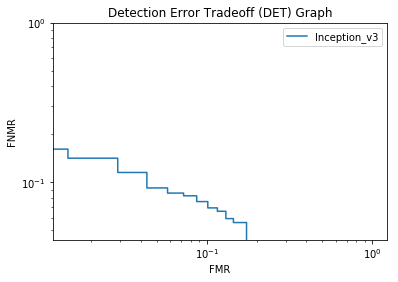

In [183]:
 """
        INPUTS: 
        
                 score_matrix: np.array(n_images_test, classes)
            decision_matrix_T: np.array(n_images_test, classes) (computed using provided T value)
                            T: Float [0.0, 1.0]
                 labels_train: np.array(n_images_train,)
                  labels_test: np.array(n_images_test,)
                            K: int (number of threshold values to use when plotting DET graph)
                   model_name: String
                 dataset_name: String
                
        OUTPUTS: None
        
    """

evaluate_predictions(score_matrix, T, labels_train, labels_test, K, model_name, dataset_name)